In [2]:
import tensorly as tl
import numpy as np
from tensorly.testing import assert_array_equal
import matplotlib.pyplot as plt
from scipy.misc import face
from scipy.ndimage import zoom 
from tensorly.decomposition import parafac
from tensorly.decomposition import tucker
from math import ceil 

## Create a tensor (it is nothing but a numpy array)

In [3]:
# orig_tensor = tl.tensor(np.arange(384).reshape((24, 4, 4)))
img = face()

/tmp/ipykernel_115403/265961090.py:2: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  img = face()


In [6]:
type(img)

numpy.ndarray

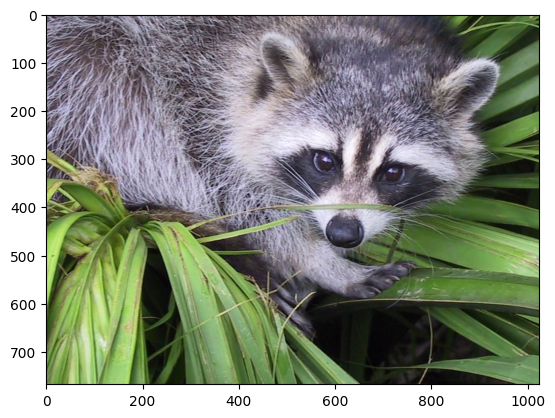

In [8]:
imgplot = plt.imshow(img)

/tmp/ipykernel_74144/2194755669.py:1: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  imgplot = plt.imshow(zoom(face(), (0.3, 0.3, 1)))


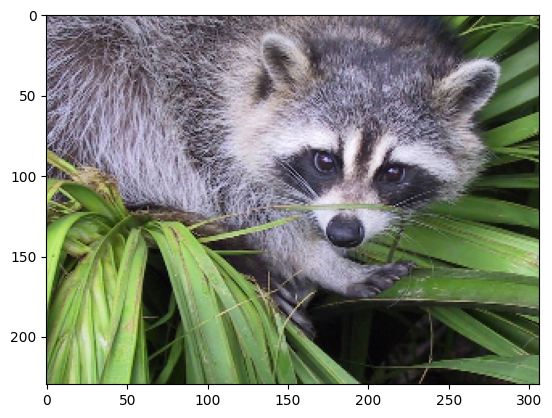

In [9]:
imgplot = plt.imshow(zoom(face(), (0.3, 0.3, 1)))

In [10]:
#Represent the image as a tensor
img = tl.tensor(face(), dtype='float64') 

/tmp/ipykernel_74144/943772043.py:2: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  img = tl.tensor(face(), dtype='float64')


In [11]:
img.shape

(768, 1024, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


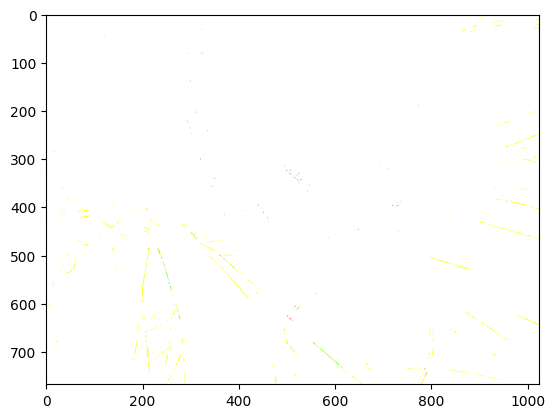

In [12]:
imgplot = plt.imshow(img)

## Define a function to convert image tensor’s datatype from float to unsigned integer

In [13]:
def to_img(tensor):
    #Convert the tensor to a numpy array
    image = tl.to_numpy(tensor)
    #Subtract minimum element from the array from each of the elements
    image -= image.min()
    #Divide the modified elements by the maximum array element
    image /= image.max()
    #Multiply the elements by 255 (0-255 is pixel range for colored images)
    image *= 255
    #Change the datatype to unit8 (unsigned integer)
    return image.astype(np.uint8)

## Define ranks of decomposition

In [14]:
# Rank of CP decomposition
cp_rank = 25
# Rank of Tucker decomposition
tucker_rank = [100, 100, 2] 

## Perform CP decomposition

In [15]:
weights, factors = parafac(img, rank=cp_rank, init='random', tol=10e-6)
# Reconstruct the image from the factors
cp_rec = tl.cp_to_tensor((weights, factors))

## Perform Tucker decomposition

In [16]:
core, factors = tucker(img, rank=tucker_rank, init='random', tol=10e-5, 
random_state=12345)
#Convert the tucker tensor into a full tensor
tucker_rec = tl.tucker_to_tensor((core, factors)) 

## Factor figures

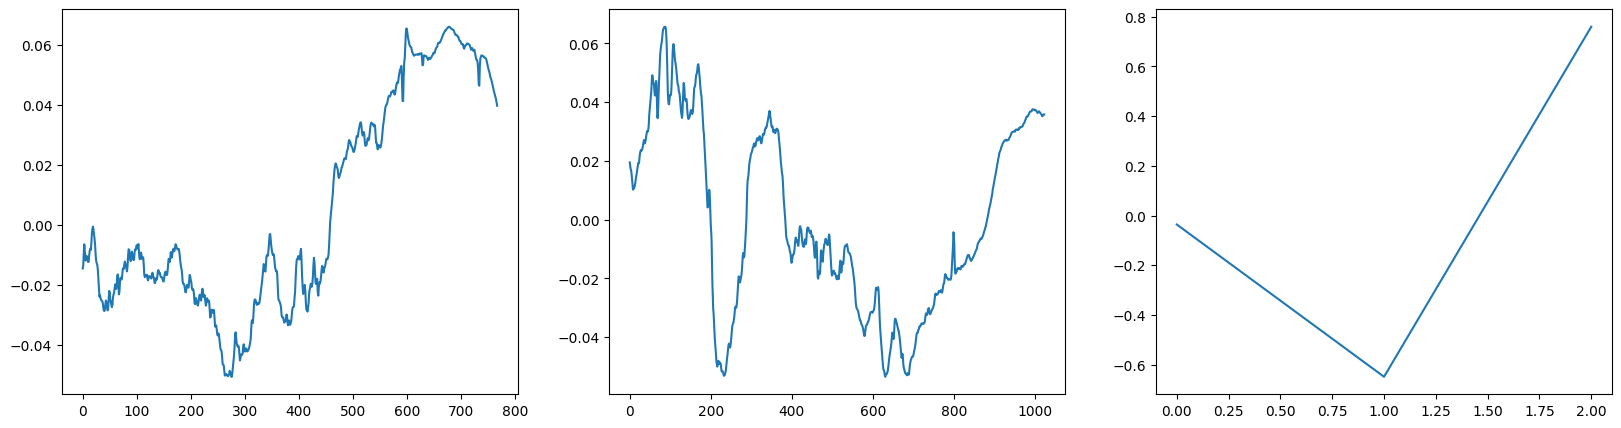

In [43]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 3, 1) 
ax.plot(np.transpose(factors[0])[1])
ax = fig.add_subplot(1, 3, 2) 
ax.plot(np.transpose(factors[1])[1])
ax = fig.add_subplot(1, 3, 3) 
ax.plot(np.transpose(factors[2])[1])

In [27]:
factors[0].shape

(768, 100)

In [18]:
tucker_rec.shape

(768, 1024, 3)

## Plot original figure, plot the image compressed using CP decomposition and Tucker decomposition.

In [118]:
%matplotlib inline

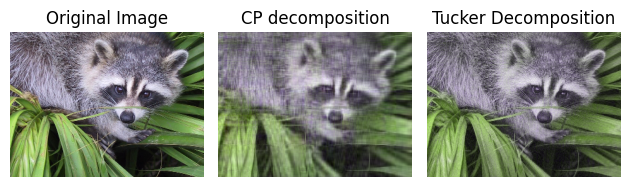

In [119]:
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1) 
#arguments represent (number of rows, number of columns, index)
ax.set_axis_off() #Turn the X and Y axes off
ax.imshow(to_img(img))  #Display the plot
ax.set_title('Original Image') #Title of the plot
ax = fig.add_subplot(1, 3, 2)
ax.set_axis_off()
ax.imshow(to_img(cp_rec))
ax.set_title('CP decomposition')
ax = fig.add_subplot(1, 3, 3)
ax.set_axis_off()
ax.imshow(to_img(tucker_rec))
ax.set_title('Tucker Decomposition')
#Adjust the padding between and around the subplots
plt.tight_layout()
#Display the plots
plt.show()

## Tensor regression example

In [147]:
import matplotlib.pyplot as plt
from tensorly.base import tensor_to_vec, partial_tensor_to_vec
from tensorly.datasets.synthetic import gen_image
from tensorly import check_random_state
from tensorly.regression.cp_regression import CPRegressor
import tensorly as tl

In [148]:
img_ht = 25 #height of the image
img_width = 25 #width of the image
# shape of the images
patterns = ['swiss', 'circle']
# ranks for testing
ranks = [1, 2, 3, 4, 5] 

In [149]:
r = check_random_state(1)
#Tensor representation of the samples
X = tl.tensor(r.normal(size=(1000, img_ht, img_width), loc=0,  
scale=1))
#numpy.random.RandomState.normal() draws random samples from a normal distribution 

In [150]:
n_rows = len(patterns)
n_columns = len(ranks) + 1 

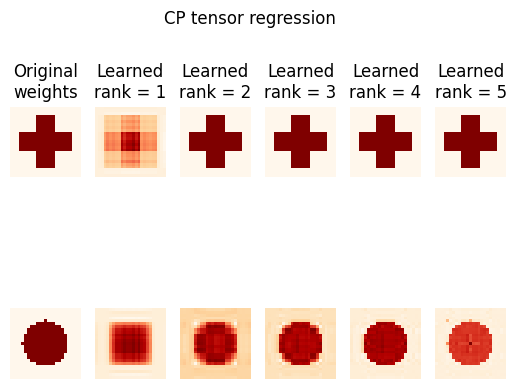

In [153]:
fig = plt.figure()
for i, pattern in enumerate(patterns):
    # Generate the original image for regression testing
    wt_img = gen_image(region=pattern, image_height=img_ht,image_width=img_width)
    wt_img = tl.tensor(wt_img)#Convert the image into tensor

    # Generate the labels
    y = tl.dot(partial_tensor_to_vec(X, skip_begin=1),tensor_to_vec(wt_img))

    # Plot the original weights
    ax = fig.add_subplot(n_rows, n_columns, i*n_columns + 1)
    ax.imshow(tl.to_numpy(wt_img), cmap=plt.cm.OrRd,interpolation='nearest')
    ax.set_axis_off()
    
    if i == 0:
        ax.set_title('Original\nweights')
    for j, rank in enumerate(ranks):
        # Create a tensor Regressor estimator
        est = CPRegressor(weight_rank=rank, tol=10e-7, n_iter_max=100,reg_W=1, verbose=0)
        # Fit the estimator to the data
        est.fit(X, y)
        #Plot the images after regression
        ax = fig.add_subplot(n_rows, n_columns, i*n_columns + j + 2)
        ax.imshow(tl.to_numpy(est.weight_tensor_), cmap=plt.cm.OrRd,interpolation='nearest')
        ax.set_axis_off()
        if i == 0:
            ax.set_title('Learned\nrank = {}'.format(rank))
plt.suptitle("CP tensor regression") #Add a centered title to the figure
plt.show() #Display the plot